In [72]:
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from mpl_interactions import ioff, panhandler, zoom_factory
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
import sys
from datetime import datetime
from scipy.optimize import curve_fit
from lmfit import Model

In [2]:
file = "../data/analysis/Run_13850_Filtered.h5"
file = "../data/analysis/Run_13850_FilteredRaw.h5"
file = "../data/analysis/Run_14180_FilteredRaw.h5"

# Load the data
data = pd.read_hdf(file, "data")
data_properties = pd.read_hdf(file, "data_properties")

# Convert 'event' columns to integers
data['event'] = data['event'].astype(int)
data_properties['event'] = data_properties['event'].astype(int)

# Get event_ids where 'x' or 'y' has NaN values
nan_event_ids = data_properties[data_properties['x'].isna()]['event'].values
nan_event_ids = np.append(nan_event_ids, data_properties[data_properties['y'].isna()]['event'].values)

# Filter out rows in data and data_properties based on the 'event' column
data_properties = data_properties[~data_properties['event'].isin(nan_event_ids)]
data = data[~data['event'].isin(nan_event_ids)]

# Check if there are still NaN values
print(data.isna().sum())
print(data_properties.isna().sum())
display(data)

display(data_properties)
print(len(data_properties.event.unique()))

event        0
ts_raw       0
pmt          0
pe_int       0
peak_time    0
noise_thr    0
ts           0
dtype: int64
event          0
S2_area        0
cath_area      0
ts_raw         0
deltaT         0
sigma          0
S2_amp         0
x              0
y              0
grass_peaks    0
nS1            0
ts             0
dtype: int64


,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,27760,1.723015e+09,0,927.88992,1393.375,109.827369,2024-08-07 02:12:55.076
1,27760,1.723015e+09,0,829.00992,1396.225,109.827369,2024-08-07 02:12:55.076
2,27760,1.723015e+09,0,1916.68992,1400.800,109.827369,2024-08-07 02:12:55.076
3,27760,1.723015e+09,0,1685.96992,1424.500,109.827369,2024-08-07 02:12:55.076
4,27760,1.723015e+09,0,2147.40992,1498.625,109.827369,2024-08-07 02:12:55.076
...,...,...,...,...,...,...,...
46858,17010,1.723014e+09,59,1754.34552,1496.200,124.997392,2024-08-07 02:03:22.813
46859,17010,1.723014e+09,59,1345.02552,1530.075,124.997392,2024-08-07 02:03:22.813
46860,17010,1.723014e+09,59,662.82552,1558.600,124.997392,2024-08-07 02:03:22.813
46861,17010,1.723014e+09,59,1310.91552,1578.100,124.997392,2024-08-07 02:03:22.813


,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,nS1,ts
0,27760,3.620563e+08,8.506972e+05,1.723015e+09,91.375,3.288948,1.151331e+06,149.925,-371.075,0.0,1.0,2024-08-07 02:12:55.076
1,27767,3.720135e+08,2.093862e+06,1.723015e+09,682.400,5.186409,7.778402e+05,-204.725,106.975,0.0,1.0,2024-08-07 02:12:55.614
2,27774,5.119326e+08,1.409290e+06,1.723015e+09,-999.000,6.114938,8.962126e+05,26.525,-78.625,1.0,2.0,2024-08-07 02:12:55.943
3,27781,3.621512e+08,1.005992e+06,1.723015e+09,738.350,5.188740,7.415586e+05,-126.975,-31.975,0.0,1.0,2024-08-07 02:12:56.134
4,27788,3.657642e+08,1.595617e+06,1.723015e+09,782.750,5.694477,6.884924e+05,26.525,-325.425,1.0,1.0,2024-08-07 02:12:56.454
...,...,...,...,...,...,...,...,...,...,...,...,...
76,16982,3.551584e+08,8.077018e+05,1.723014e+09,20.125,1.968122,1.719874e+06,26.525,-340.975,1.0,1.0,2024-08-07 02:03:21.263
77,16989,3.609424e+08,9.058487e+05,1.723014e+09,383.925,4.195236,9.142734e+05,-50.225,-202.025,0.0,1.0,2024-08-07 02:03:21.857
78,16996,4.747582e+08,1.596115e+06,1.723014e+09,-999.000,5.906331,8.808324e+05,-281.475,14.175,0.0,2.0,2024-08-07 02:03:22.292
79,17003,3.995238e+08,1.158700e+06,1.723014e+09,802.300,5.696795,7.434718e+05,-173.625,230.375,0.0,1.0,2024-08-07 02:03:22.531


50866


In [3]:
# Rebin the x and y

# Define bin edges using np.linspace for x and y
x_bins = np.linspace(-500, 500, 10)  # 10 evenly spaced bins between -500 and 500
y_bins = np.linspace(-500, 500, 10)

# Bin the x and y columns
data_properties['x_bin'] = pd.cut(data_properties['x'], bins=x_bins, labels=False)  # Labels as index (0, 1, 2,...)
data_properties['y_bin'] = pd.cut(data_properties['y'], bins=y_bins, labels=False)

# Calculate bin centers
x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2  # Bin centers for x
y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Bin centers for y

# Assign the bin centers as new columns
data_properties['x_bin_center'] = data_properties['x_bin'].map(lambda i: x_bin_centers[i] if pd.notna(i) else np.nan)
data_properties['y_bin_center'] = data_properties['y_bin'].map(lambda i: y_bin_centers[i] if pd.notna(i) else np.nan)

# Assign a unique bin ID for each (x_bin, y_bin) pair
data_properties['bin_id'] = data_properties['x_bin'].astype(str) + '_' + data_properties['y_bin'].astype(str)

display(data_properties)

,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,nS1,ts,x_bin,y_bin,x_bin_center,y_bin_center,bin_id
0,27760,3.620563e+08,8.506972e+05,1.723015e+09,91.375,3.288948,1.151331e+06,149.925,-371.075,0.0,1.0,2024-08-07 02:12:55.076,5,1,111.111111,-333.333333,5_1
1,27767,3.720135e+08,2.093862e+06,1.723015e+09,682.400,5.186409,7.778402e+05,-204.725,106.975,0.0,1.0,2024-08-07 02:12:55.614,2,5,-222.222222,111.111111,2_5
2,27774,5.119326e+08,1.409290e+06,1.723015e+09,-999.000,6.114938,8.962126e+05,26.525,-78.625,1.0,2.0,2024-08-07 02:12:55.943,4,3,0.000000,-111.111111,4_3
3,27781,3.621512e+08,1.005992e+06,1.723015e+09,738.350,5.188740,7.415586e+05,-126.975,-31.975,0.0,1.0,2024-08-07 02:12:56.134,3,4,-111.111111,0.000000,3_4
4,27788,3.657642e+08,1.595617e+06,1.723015e+09,782.750,5.694477,6.884924e+05,26.525,-325.425,1.0,1.0,2024-08-07 02:12:56.454,4,1,0.000000,-333.333333,4_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,16982,3.551584e+08,8.077018e+05,1.723014e+09,20.125,1.968122,1.719874e+06,26.525,-340.975,1.0,1.0,2024-08-07 02:03:21.263,4,1,0.000000,-333.333333,4_1
77,16989,3.609424e+08,9.058487e+05,1.723014e+09,383.925,4.195236,9.142734e+05,-50.225,-202.025,0.0,1.0,2024-08-07 02:03:21.857,4,2,0.000000,-222.222222,4_2
78,16996,4.747582e+08,1.596115e+06,1.723014e+09,-999.000,5.906331,8.808324e+05,-281.475,14.175,0.0,2.0,2024-08-07 02:03:22.292,1,4,-333.333333,0.000000,1_4
79,17003,3.995238e+08,1.158700e+06,1.723014e+09,802.300,5.696795,7.434718e+05,-173.625,230.375,0.0,1.0,2024-08-07 02:03:22.531,2,6,-222.222222,222.222222,2_6


In [4]:
print(len(nan_event_ids))

1194


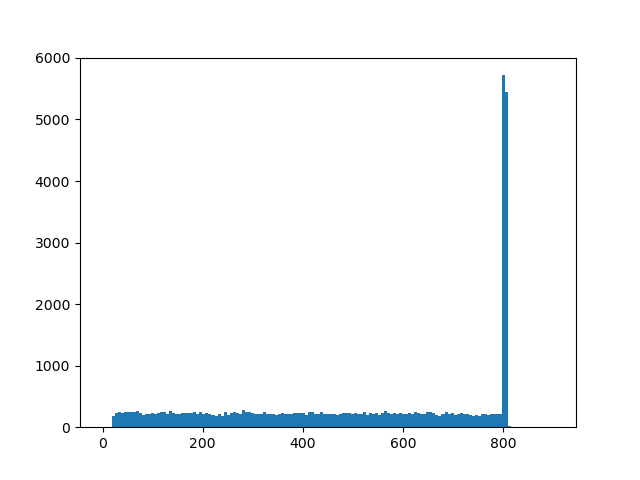

In [5]:
%matplotlib widget
plt.figure()

plt.hist(data_properties.deltaT, bins = np.linspace(0, 900, 150));

False


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_29217/97392186.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


Text(0, 0.5, 'Y [mm]')

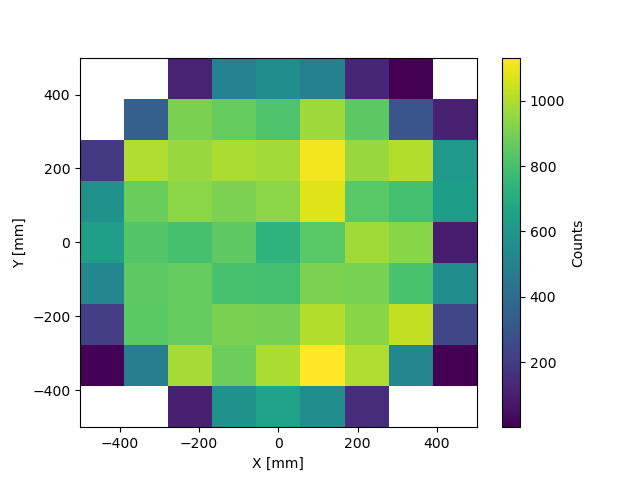

In [6]:
fig, ax = plt.subplots()
has_nan = data_properties['x'].isna().any()
print(has_nan)

hist, xedges, yedges = np.histogram2d(data_properties.x, data_properties.y, bins=[np.linspace(-500,500,10),np.linspace(-500,500,10)])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram

pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")



/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_29217/4096178390.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


Text(0, 0.5, 'Cathode PE Area [ADC]')

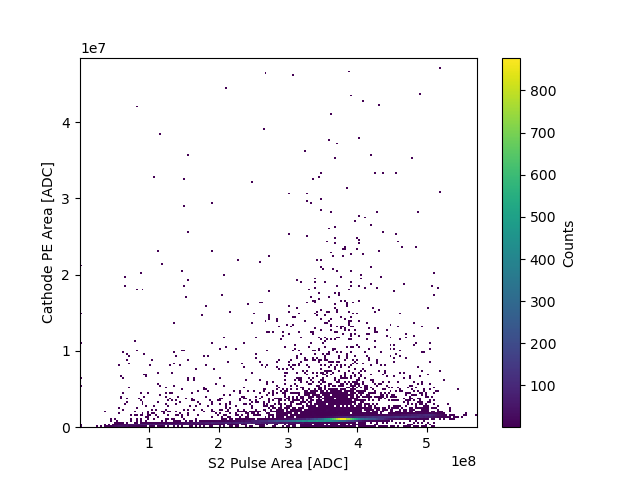

In [145]:

# 1. Create the 2D histogram

data_properties_active = data_properties[ (data_properties.deltaT>0) & (data_properties.deltaT<794)]

# hist, xedges, yedges = np.histogram2d(data_properties_active.S2_area, data_properties_active.cath_area, bins=100)
hist, xedges, yedges = np.histogram2d(data_properties.S2_area, data_properties.cath_area, bins=200)

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram
fig, ax = plt.subplots()
pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("S2 Pulse Area [ADC]")
plt.ylabel("Cathode PE Area [ADC]")


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_29217/1820563303.py:51: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


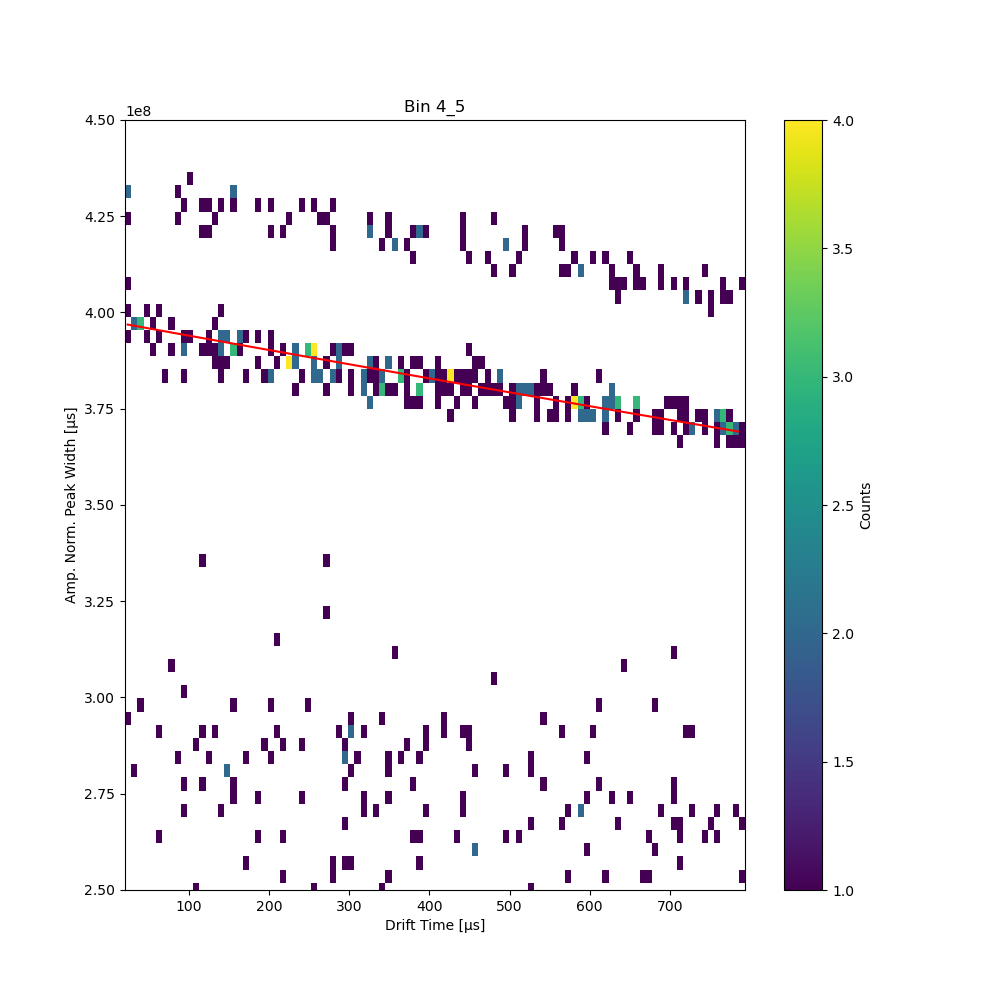

In [142]:
# Define the exponential decay function
def exp_decay(t, q, tau):
    return q * np.exp(-t / tau)

def FitLifetime(df, binid):

    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == binid] 

    # Get the histogram with the most counts to find the main alpha peak
    counts, bin_edges = np.histogram(df_bin.S2_area, bins=50) 
    max_bin_index = np.argmax(counts)  # Index of the bin with the most counts
    max_bin_value = bin_edges[max_bin_index]  # Left edge of the bin with the most counts

    lower_bound = max_bin_value-0.25e8 + 0.3e8
    upper_bound = max_bin_value+0.25e8 + 0.3e8

    df_bin = df_bin[ (df_bin.S2_area > -5e4*df_bin.deltaT+lower_bound) & (df_bin.S2_area < -5e4*df_bin.deltaT+upper_bound)  ]

    if (len(df_bin) < 20):
        return 0, 0

    # Make 2D hist for binning
    hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=100)
    
    # Perform the curve fit
    params, covariance = curve_fit(exp_decay, df_bin.deltaT, df_bin.S2_area, p0=[max_bin_value, 80e3 ], bounds = ([1e8, 1e3], [4.5e8, 100e3]))


    # Extract the fitted parameters
    q_fit, tau_fit = params
    # print(q_fit/1e8, tau_fit/1e3 )

    return q_fit, tau_fit


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Filter data based on the current bin_id
df_bin = data_properties_active[data_properties_active.bin_id == "4_5"] # 4_5, 


# Create 2D histogram
hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=100)

# Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# Custom colormap
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# Plot with pcolormesh
pcm = ax.pcolormesh(x_edges, y_edges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

# Set labels
ax.set_xlabel("Drift Time [μs]")
ax.set_ylabel("Amp. Norm. Peak Width [μs]")
ax.set_title(f"Bin 4_5")
ax.set_ylim(2.5e8,4.5e8)

# # Generate fitted curve
t_fit = np.linspace(min(x_for_fit), max(x_for_fit), 100)

q_fit, tau_fit = FitLifetime(data_properties_active, "4_5")
hist_fit = exp_decay(t_fit, q_fit, tau_fit)

# # Plotting the fitted exponential decay curve
ax.plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')



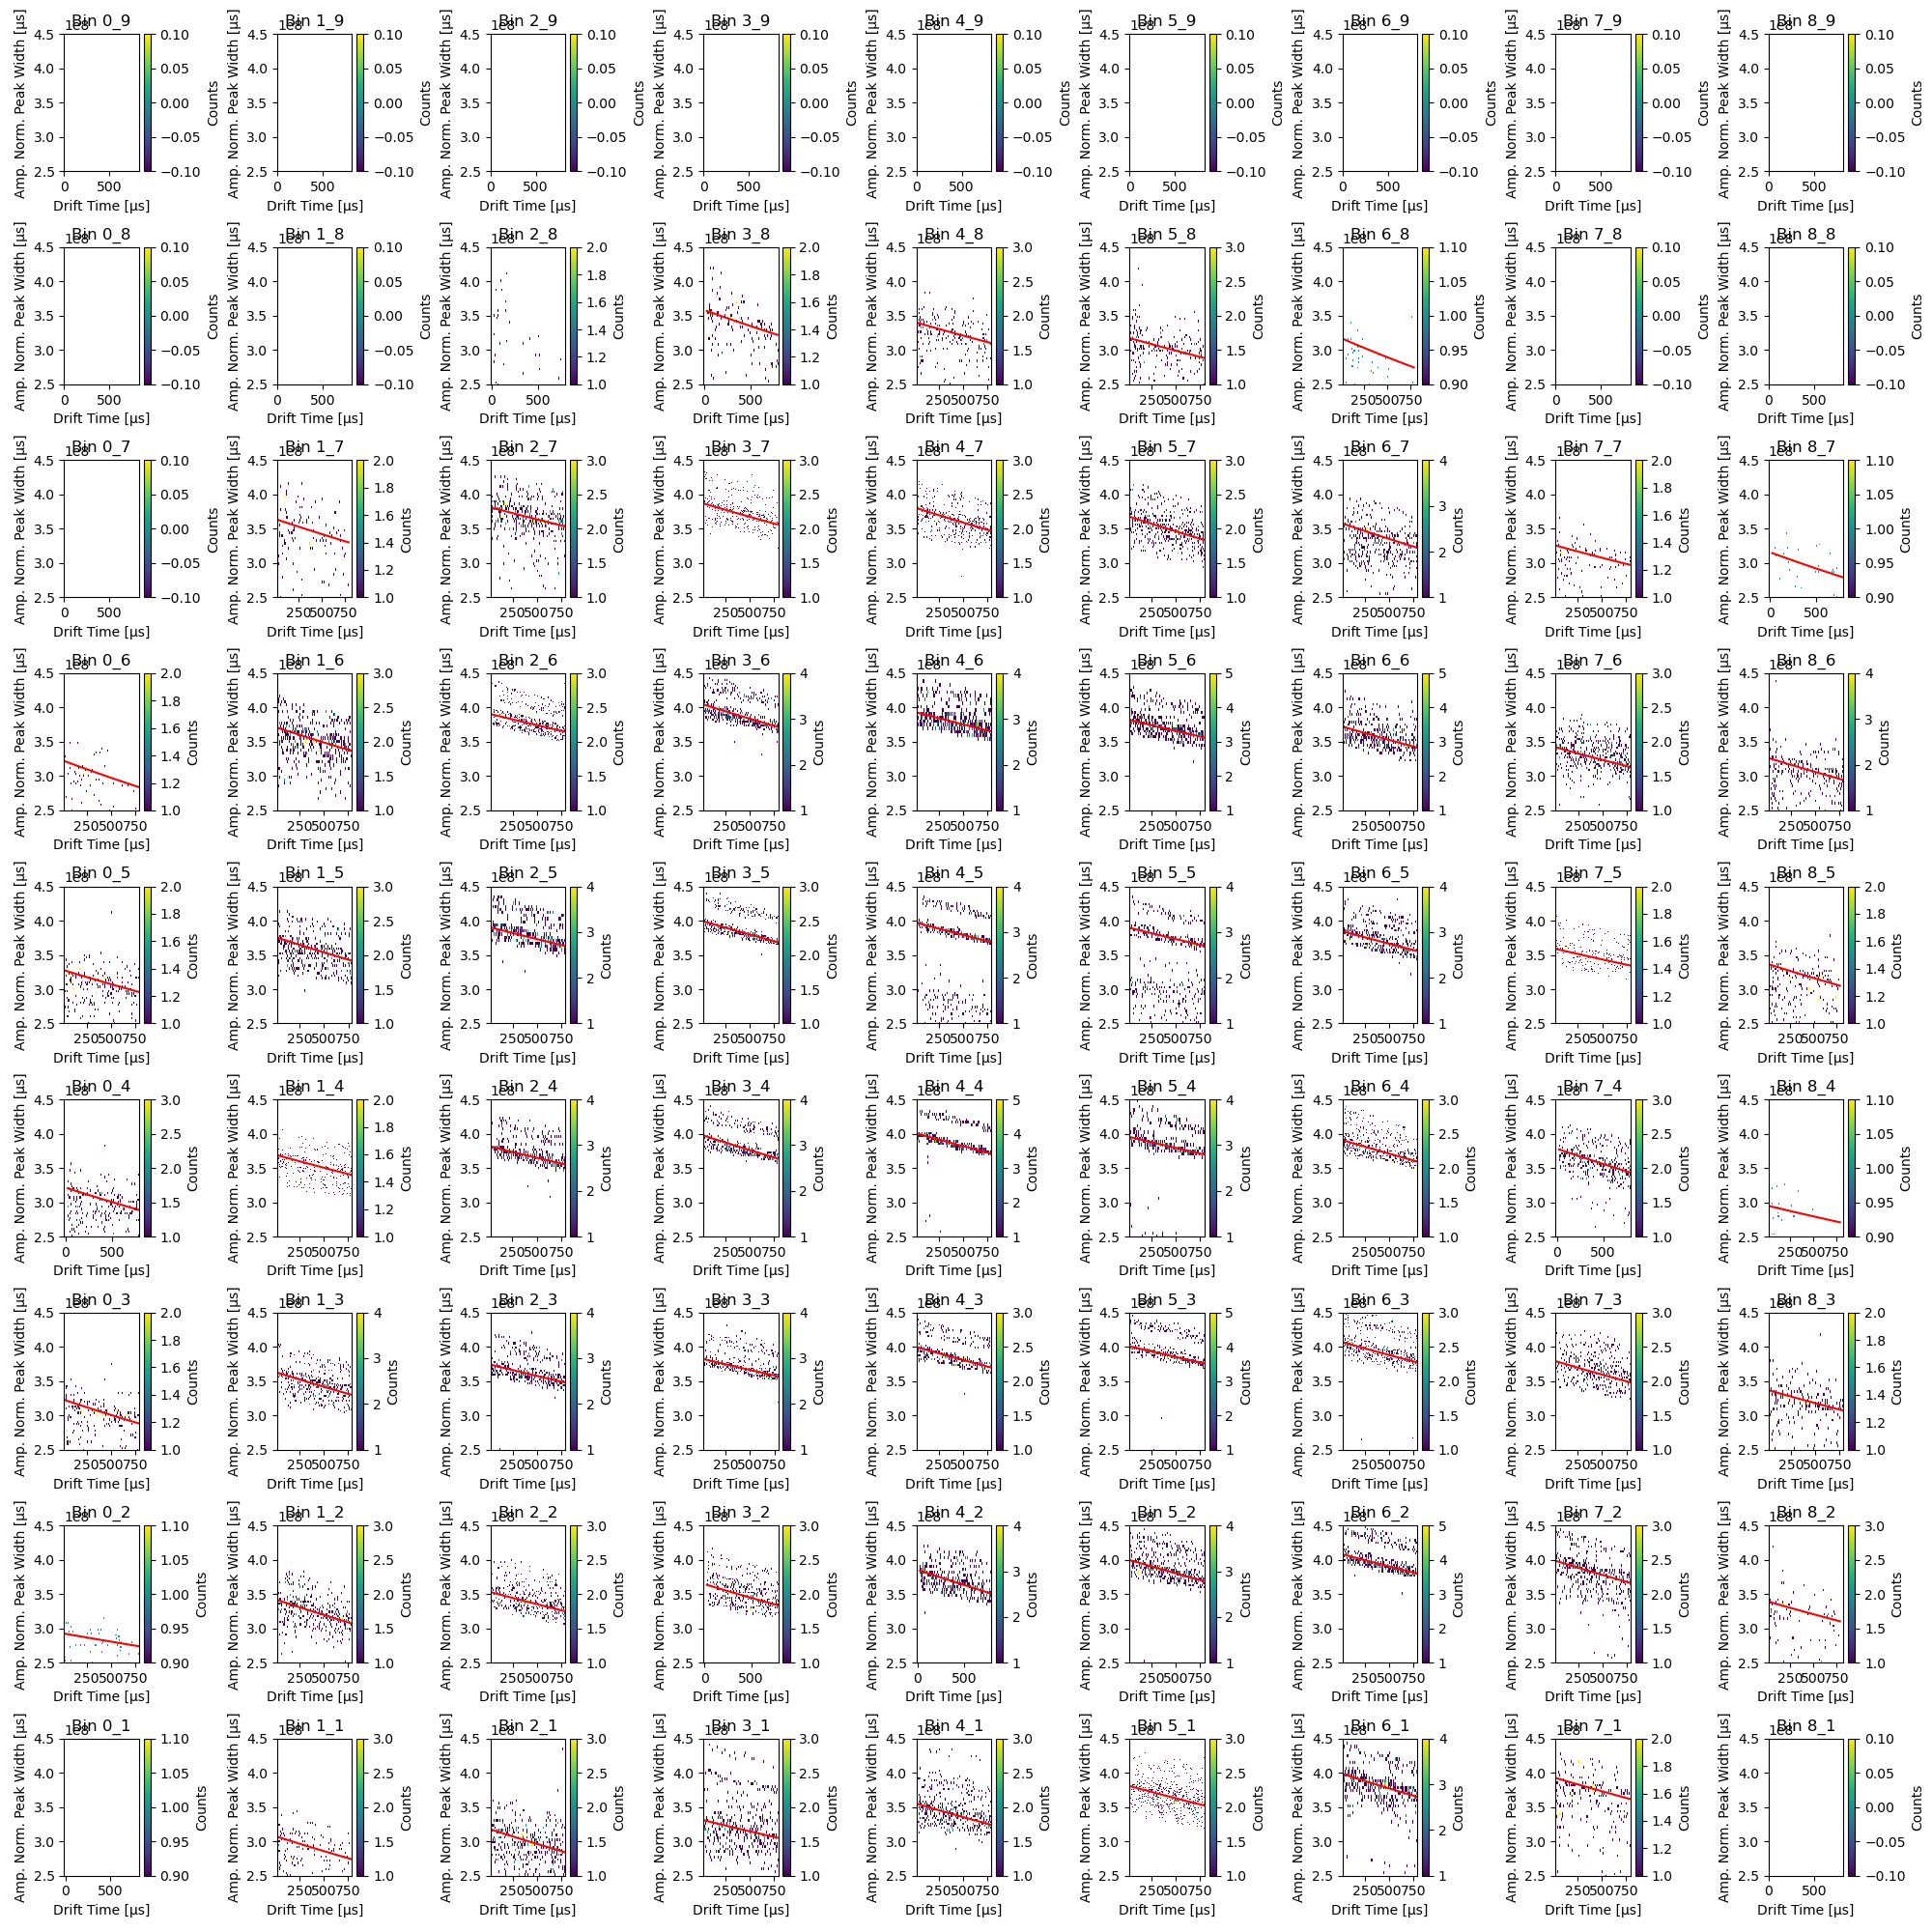

,bin_id,lt,q0
0,0_9,0,0
1,1_9,0,0
2,2_9,0,0
3,3_9,0,0
4,4_9,0,0
...,...,...,...
76,4_1,8460.102706,356051945.084599
77,5_1,9980.885235,381593449.053654
78,6_1,8781.782787,399473675.538917
79,7_1,9406.762999,393550696.400913


In [170]:
# Make a plot of the time vs peak width

data_properties_active['sigma'] = data_properties_active['sigma'].fillna(0)
data_properties_active['S2_amp'] = data_properties_active['S2_amp'].fillna(-1)

data_properties_active = data_properties_active[data_properties_active.S2_amp > 0]




# Define the plot function
def plot_lifetime(ax, df, S2var, bin_id):
    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == bin_id]

    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(df_bin['deltaT'], df_bin[S2var], bins=100)

    # Mask zero bins
    masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

    # Custom colormap
    # cmap = plt.cm.viridis
    cmap = plt.cm.get_cmap("viridis").copy()
    cmap.set_bad(color='white')  # Set masked values (zeros) to white

    # Plot with pcolormesh
    pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

    # Add color bar
    plt.colorbar(pcm, ax=ax, label='Counts')

    # Set labels
    ax.set_xlabel("Drift Time [μs]")
    ax.set_ylabel("Amp. Norm. Peak Width [μs]")
    ax.set_title(f"Bin {bin_id}")
    ax.set_ylim(2.5e8,4.5e8)


# Create a grid of subplots (5x5)
fig, axs = plt.subplots(9, 9, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

lifetime_df = pd.DataFrame(columns=["bin_id", "lt", "q0"])

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(9, -1, -1):
    for x in range(0, 9, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        plot_lifetime(axs[counter], data_properties_active, "S2_area",f"{x}_{y}")

        t_fit = np.linspace(min(x_for_fit), max(x_for_fit), 100)

        q_fit, tau_fit = FitLifetime(data_properties_active, f"{x}_{y}")
        hist_fit = exp_decay(t_fit, q_fit, tau_fit)

        # # Plotting the fitted exponential decay curve
        axs[counter].plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')

        # Create a new DataFrame to append
        new_data = pd.DataFrame({
            "bin_id": [f"{x}_{y}"],
            "lt": [tau_fit],
            "q0": [q_fit]
        })

        lifetime_df = pd.concat([lifetime_df, new_data], ignore_index=True)

        counter=counter+1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

display(lifetime_df)


,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,...,ts,x_bin,y_bin,x_bin_center,y_bin_center,bin_id,lt,q0,S2_areaC,R
0,27760,3.620563e+08,8.506972e+05,1.723015e+09,91.375,3.288948,1.151331e+06,149.925,-371.075,0.0,...,2024-08-07 02:12:55.076,5,1,111.111111,-333.333333,5_1,9980.885235,381593449.053654,3.915739e+08,400.217642
1,27767,3.720135e+08,2.093862e+06,1.723015e+09,682.400,5.186409,7.778402e+05,-204.725,106.975,0.0,...,2024-08-07 02:12:55.614,2,5,-222.222222,111.111111,2_5,10667.743829,391047856.719784,4.147368e+08,230.989126
2,27781,3.621512e+08,1.005992e+06,1.723015e+09,738.350,5.188740,7.415586e+05,-126.975,-31.975,0.0,...,2024-08-07 02:12:56.134,3,4,-111.111111,0.000000,3_4,8610.491833,398558337.112458,4.048568e+08,130.939113
3,27788,3.657642e+08,1.595617e+06,1.723015e+09,782.750,5.694477,6.884924e+05,26.525,-325.425,1.0,...,2024-08-07 02:12:56.454,4,1,0.000000,-333.333333,4_1,8460.102706,356051945.084599,4.608212e+08,326.504221
4,27795,2.479531e+08,6.200161e+05,1.723015e+09,145.900,3.235227,8.012001e+05,412.275,-48.025,0.0,...,2024-08-07 02:12:56.864,8,4,444.444444,0.000000,8_4,9007.359219,295425380.94208,3.488341e+08,415.062738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28624,16961,3.951035e+08,1.189783e+06,1.723014e+09,487.125,4.676535,9.024124e+05,10.975,276.025,0.0,...,2024-08-07 02:03:19.939,4,6,0.000000,222.222222,4_6,10544.034287,393812254.806386,4.296831e+08,276.243102
28625,16968,4.387904e+08,1.196245e+06,1.723014e+09,53.525,2.596031,1.644214e+06,196.575,29.225,0.0,...,2024-08-07 02:03:20.355,6,4,222.222222,0.000000,6_4,9242.411665,391609449.124091,4.608734e+08,198.735581
28626,16982,3.551584e+08,8.077018e+05,1.723014e+09,20.125,1.968122,1.719874e+06,26.525,-340.975,1.0,...,2024-08-07 02:03:21.263,4,1,0.000000,-333.333333,4_1,8460.102706,356051945.084599,4.088881e+08,342.005155
28627,16989,3.609424e+08,9.058487e+05,1.723014e+09,383.925,4.195236,9.142734e+05,-50.225,-202.025,0.0,...,2024-08-07 02:03:21.857,4,2,0.000000,-222.222222,4_2,8373.188642,385510896.545803,4.008455e+08,208.174569


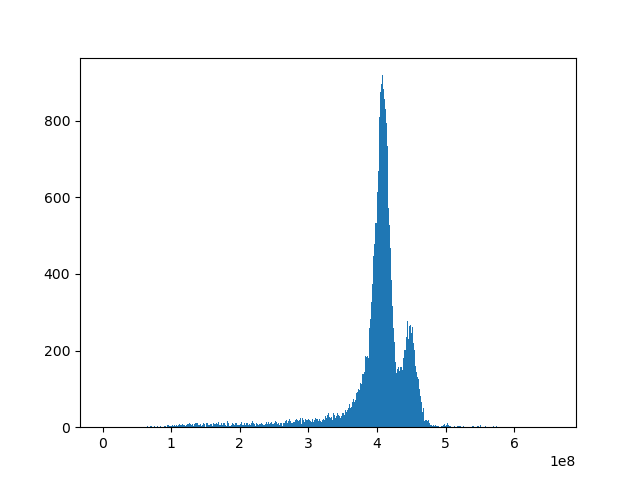

In [181]:
# Plot the alpha map of

def CorrectLifetime(row, q0_max):

    lt = row["lt"]
    time = row["deltaT"]
    q0 = row["q0"]

    if (q0 == 0):
        q_corr = 1
    else:
        q_corr = q0_max/q0


    if (lt == 0):
        return 1
    else:
        return q_corr * row["S2_area"] / np.exp(-1*time/lt)


data_properties_active_lt = pd.merge(data_properties_active, lifetime_df, on="bin_id", how="left")

q0_max = np.max(data_properties_active_lt.q0)

data_properties_active_lt["S2_areaC"] = data_properties_active_lt.apply(lambda row: CorrectLifetime(row, q0_max), axis=1)

data_properties_active_lt["R"] = np.sqrt(data_properties_active_lt["x"]*data_properties_active_lt["x"] + data_properties_active_lt["y"]*data_properties_active_lt["y"])

display(data_properties_active_lt)

# Create a grid of subplots (5x5)
# fig, axs = plt.subplots(9, 9, figsize=(20, 20))  # Adjusted figsize for better spacing
# axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

# Iterate over the unique bin_id values and corresponding subplot axes
# counter = 0
# for y in range(9, -1, -1):
#     for x in range(0, 9, 1):
#         if counter >= len(axs):
#             break  # Avoid indexing beyond available subplots
#         plot_lifetime(axs[counter], data_properties_active_lt, "S2_areaC" ,f"{x}_{y}")
#         counter=counter+1


plt.figure()
plt.hist(data_properties_active_lt[data_properties_active_lt.R < 500].S2_areaC, bins = 500);


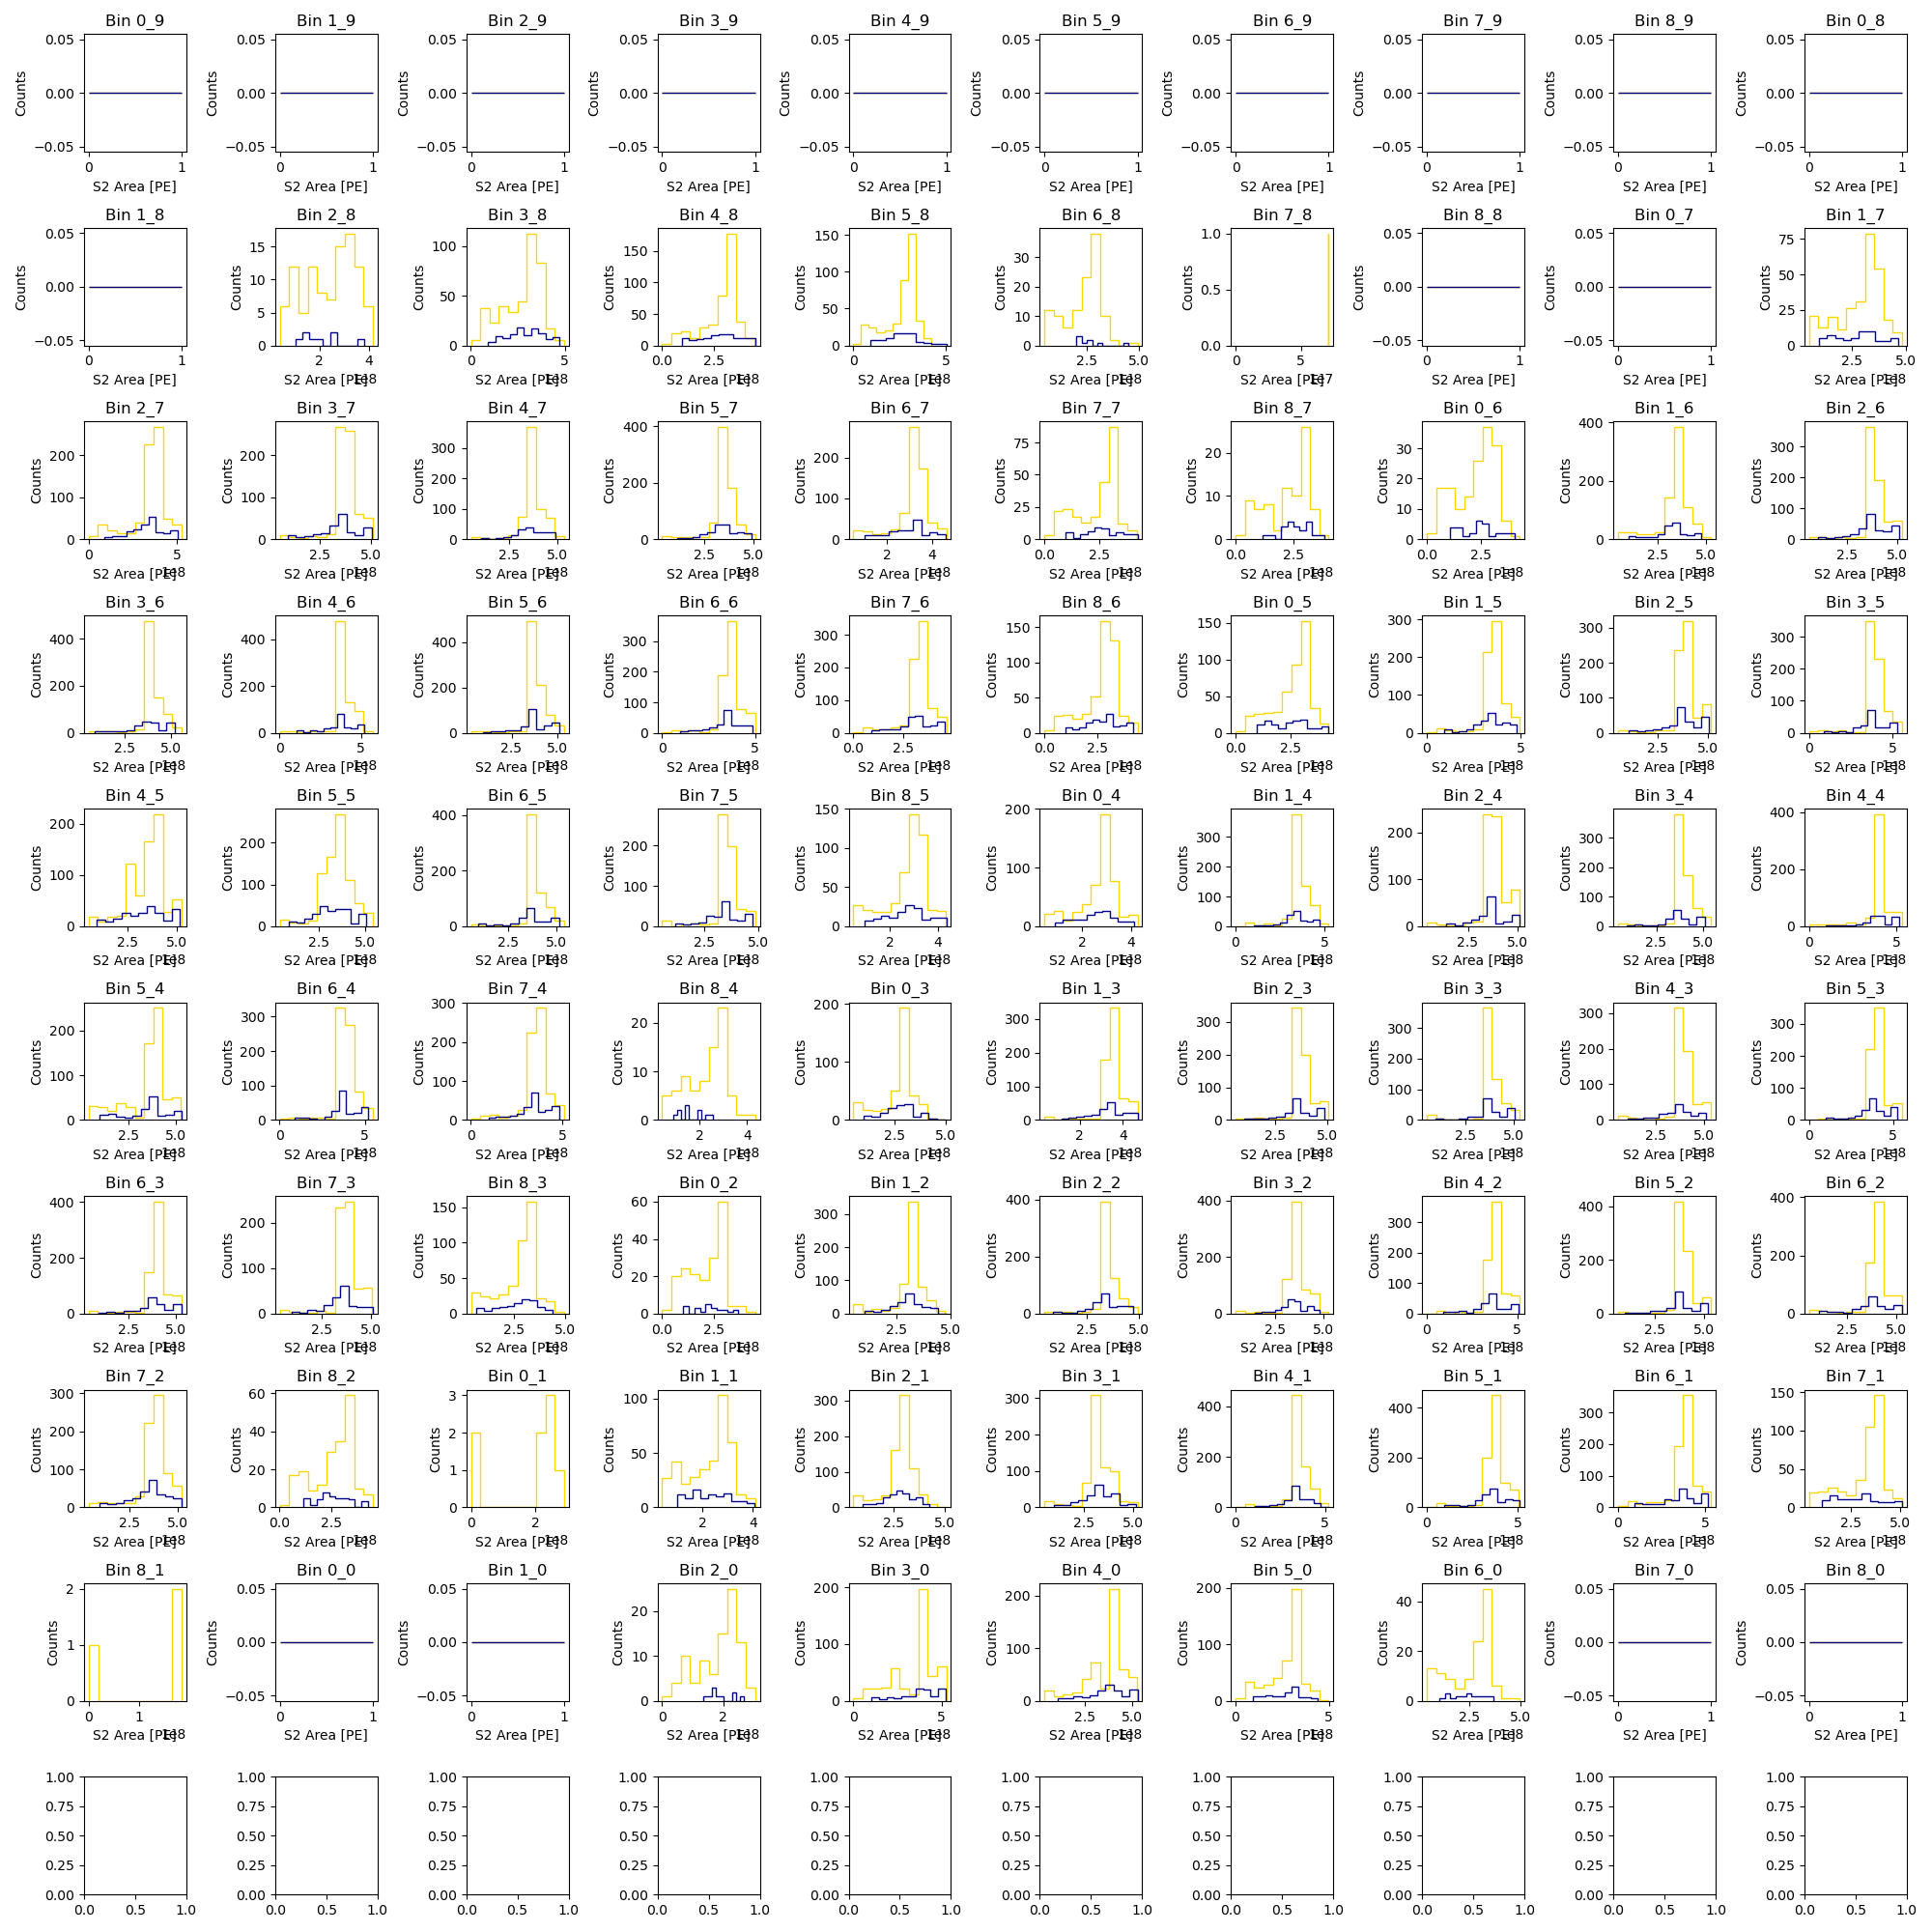

In [164]:
# Define the plot function
def plot_S2(ax, df, bin_id):
    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == bin_id]

    ax.hist(df_bin[(df_bin.deltaT<794)].S2_area, bins = 10, histtype = "step", label="Active Events", color="gold");
    ax.hist(df_bin[(df_bin.deltaT>794)].S2_area, bins = 10, histtype = "step", label="Cathode Events", color="DarkBlue");

    # Set labels
    ax.set_xlabel("S2 Area [PE]")
    ax.set_ylabel("Counts")
    ax.set_title(f"Bin {bin_id}")


# Create a grid of subplots (5x5)
fig, axs = plt.subplots(10, 10, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(9, -1, -1):
    for x in range(0, 9, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        plot_S2(axs[counter], data_properties, f"{x}_{y}")
        counter=counter+1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

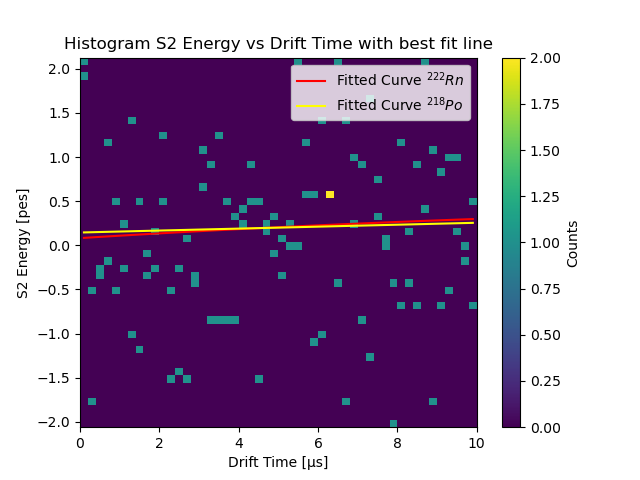

In [131]:
from scipy.optimize import curve_fit

# Assuming you already have the 2D histogram data (hist, xedges, yedges)

# Function for exponential decay with a vertical offset (S2 energy offset)
def exp_decay_with_offset(t, A, tau, offset):
    return A * np.exp(-t / tau) + offset

# Select the x (drift time) and y (S2 energy) data from the histogram
xdata = (xedges[:-1] + xedges[1:]) / 2  # Bin centers for drift time
ydata_hist = hist.sum(axis=0)  # Sum across the energy axis

# Define two energy bands for the two exponentials
# For example, selecting two different energy ranges (170000 - 190000)
y_band1 = hist[30:35, :].sum(axis=0)  # First energy band for 222Rn
y_band2 = hist[40:45, :].sum(axis=0)  # Second energy band for 218Po

# Initial guesses for fitting
initial_guess_band1 = [1000, 200, 180000]  # A, tau, offset
initial_guess_band2 = [1000, 300, 190000]  # A, tau, offset

# Fit the two independent exponential decays
popt_band1, _ = curve_fit(exp_decay_with_offset, xdata, y_band1, p0=initial_guess_band1)
popt_band2, _ = curve_fit(exp_decay_with_offset, xdata, y_band2, p0=initial_guess_band2)

# Plotting the 2D histogram and the fits
fig, ax = plt.subplots()

# Plot the original 2D histogram
pcm = ax.pcolormesh(xedges, yedges, hist.T, cmap='viridis')
plt.colorbar(pcm, ax=ax, label='Counts')

# Plot the first fitted exponential curve (222Rn)
ax.plot(xdata, exp_decay_with_offset(xdata, *popt_band1), color='red', label=r'Fitted Curve $^{222}Rn$')

# Plot the second fitted exponential curve (218Po)
ax.plot(xdata, exp_decay_with_offset(xdata, *popt_band2), color='yellow', label=r'Fitted Curve $^{218}Po$')

# Customize the plot
ax.set_xlabel('Drift Time [μs]')
ax.set_ylabel('S2 Energy [pes]')
ax.set_title('Histogram S2 Energy vs Drift Time with best fit line')

# Add labels and legends
ax.text(50, 215000, 'Run 13773', fontsize=20, color='white')
ax.legend()

plt.show()

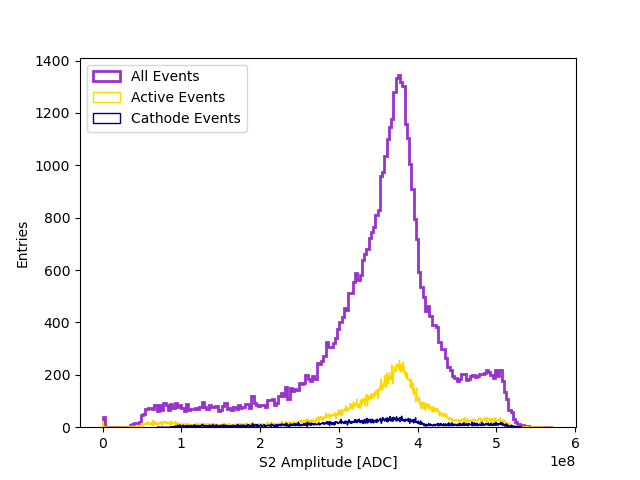

In [97]:
# Histogram the S2 energy
plt.figure()

plt.hist(data_properties.S2_area, bins = 200, histtype = "step", color = "darkorchid", linewidth=2, label = "All Events");
plt.xlabel("S2 Amplitude [ADC]")
plt.ylabel("Entries")

# plt.hist(data_properties_active[data_properties_active.cath_area < 50e3].S2_area, bins = 200, histtype = "step");
plt.hist(data_properties[(data_properties.deltaT<794)].S2_area, bins = 1000, histtype = "step", label="Active Events", color="gold");
plt.hist(data_properties[(data_properties.deltaT>794)].S2_area, bins = 1000, histtype = "step", label="Cathode Events", color="DarkBlue");
plt.legend(loc="upper left")

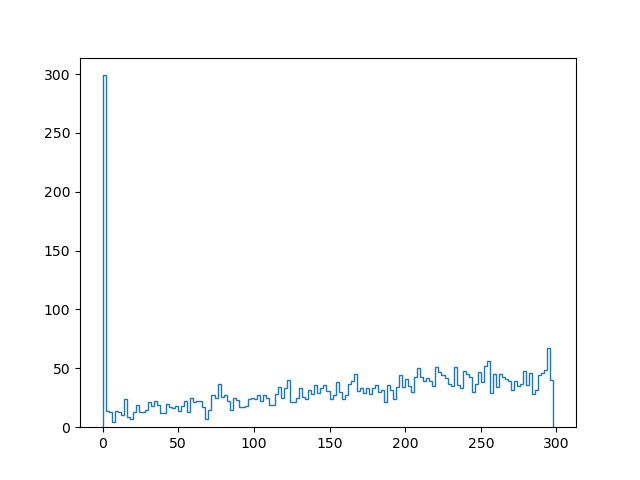

In [98]:
plt.figure()

plt.hist(data[data.pmt == 4].pe_int, bins = np.arange(0, 300, 2), histtype = "step");
# plt.semilogy()

In [99]:
data_grouped = data.groupby(['event', 'peak_time'])['pe_int'].sum().reset_index()
display(data_grouped)

KeyboardInterrupt: 

KeyboardInterrupt: 

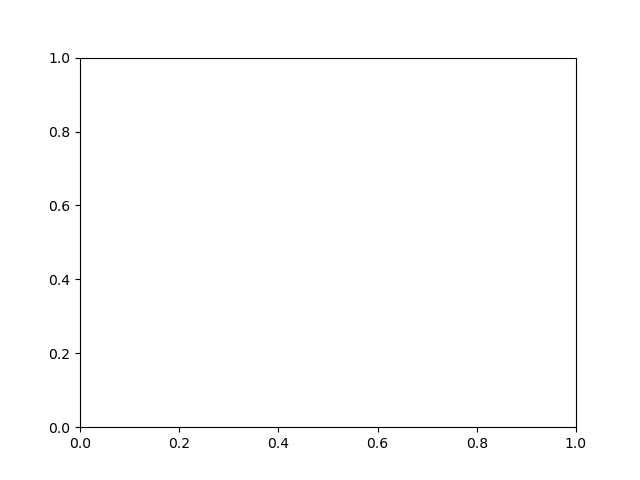

In [ ]:
fig, ax = plt.subplots()

bins = np.arange(1350, 1770,10 )
bin_centers = (bins[:-1] + bins[1:]) / 2

total_hist = None

for index, evt in enumerate(data_grouped.event.unique()):

    if index % 1000 == 0:
        print(f"Event: {index}")

    # if index > 5000:
    #     break

    S2_pulse = data_properties[data_properties['event'] == evt]

    counts, edges =np.histogram(data_grouped[data_grouped.event == evt].peak_time, weights=data_grouped[data_grouped.event == evt].pe_int, bins = bins )
    

    # hist2D, xedges, yedges = np.histogram2d(bin_centers, counts, bins=[bins, np.arange(0,4000, 25)])
    hist2D, xedges, yedges = np.histogram2d(bin_centers, counts/S2_pulse.S2_area.item(), bins=[bins, np.linspace(0,0.0005, 50)])
    
    # masked_hist=hist2D

    if total_hist is None:
        total_hist = hist2D
    else:
        total_hist += hist2D

    # print(total_hist[total_hist >0])

# 2. Mask zero bins
total_hist = np.ma.masked_where(total_hist == 0, total_hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram

pcm = ax.pcolormesh(xedges, yedges, total_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("Time [mus]")
plt.ylabel("Amplitude [ADC]")
